### Implementation of textural variation in laminated sands using digital image analysis of thin sections (van den Berg, Bense and Schlager, 2003)

Trying to implement Berg et al, 2003 pipeline for textural variation analysis in sedimentary thin sections, albeit with no good thin section to use on (used sandLaminated.jpg that I found on the internet).



In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2
import helper as hl
# Helper is a personal module where functions used in exploration notebook are stored for further use

In [147]:
FNAME = "sandLaminated.jpg"

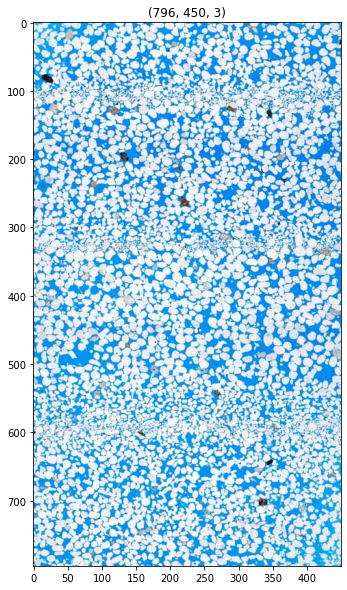

In [148]:
img = hl.load_img(FNAME)
hl.plot_rgb(img) 

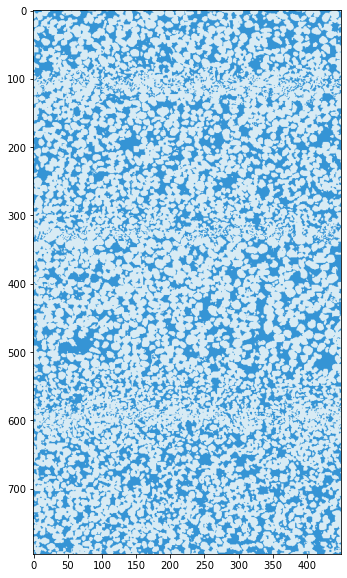

In [86]:
quantIMG = quantize_image(img[:,:,::-1], n_clusters=2)
plt.imshow(quantIMG)

In [154]:
import sys
import cv2
import numpy
from scipy.ndimage import label
from skimage.filters import threshold_otsu

def segment_grains(img, iter):
    # taken from https://stackoverflow.com/questions/25789278/coffee-beans-separation-algorithm (thanks to karlphillip)
    def segment_on_dt(a, img, iter):
        border = cv2.dilate(img, None, iterations=iter)
        border = border - cv2.erode(border, None)
        #cv2.imwrite("border.png", border)

        dt = cv2.distanceTransform(img, 2, 5)    
        dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(numpy.uint8)
        _, dt = cv2.threshold(dt, threshold_otsu(img), 255, cv2.THRESH_BINARY)
        #cv2.imwrite("dt_thres.png", dt)
        lbl, ncc = label(dt)
        lbl = lbl * (255/ncc)      
        # Completing the markers now. 
        lbl[border == 255] = 255

        lbl = lbl.astype(numpy.int32)
        #cv2.imwrite("label.png", lbl)    
        cv2.watershed(a, lbl)

        lbl[lbl == -1] = 0
        lbl = lbl.astype(numpy.uint8)
        return 255 - lbl

    # Pre-processing.
    img_gray = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)    
    _, img_bin = cv2.threshold(img_gray.astype('uint8'), threshold_otsu(img), 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #cv2.imwrite("img_bin.png", img_bin)

    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, numpy.ones((3, 3), dtype=int))
    #cv2.imwrite("img_bin_morphoEx.png", img_bin)

    result = segment_on_dt(img, img_bin, iter)
    #cv2.imwrite("result.png", result)

    result[result != 255] = 0
    result = cv2.dilate(result, None)
    img[result == 255] = (0, 0, 255)
    return result

## lacks detection of fine grains in bands but further parameter tuning in progress

<ipython-input-154-db853c04a902>:33: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (796, 450, 3) looks like an RGB image
  _, img_bin = cv2.threshold(img_gray.astype('uint8'), threshold_otsu(img), 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)


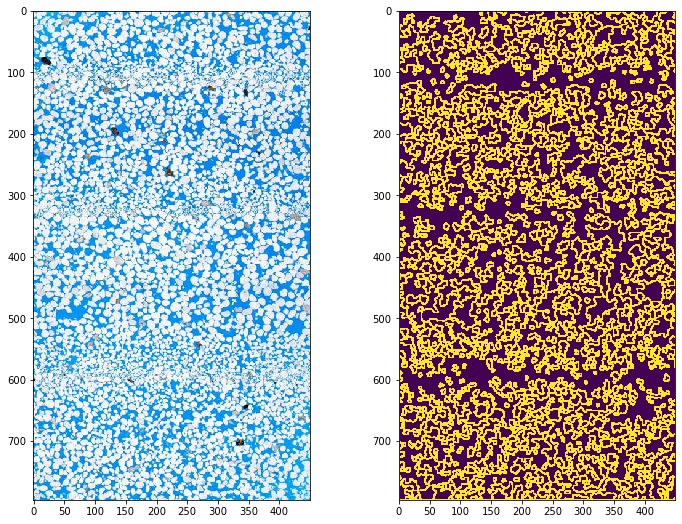

In [169]:
img = hl.load_img(FNAME)
result = segment_grains(img[:,:,::-1], iter=4)
hl.plot_images(hl.load_img(FNAME)[:,:,::-1], result)
